In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import xlrd
from datetime import timedelta,date

import sys
sys.path.append('/home/jquser')




## 2.交易列表

## 3.交易图表

/opt/conda/envs/python2new/lib/python2.7/site-packages/dateutil/parser.py:98: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  while nextchar == '\x00':
/opt/conda/envs/python2new/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


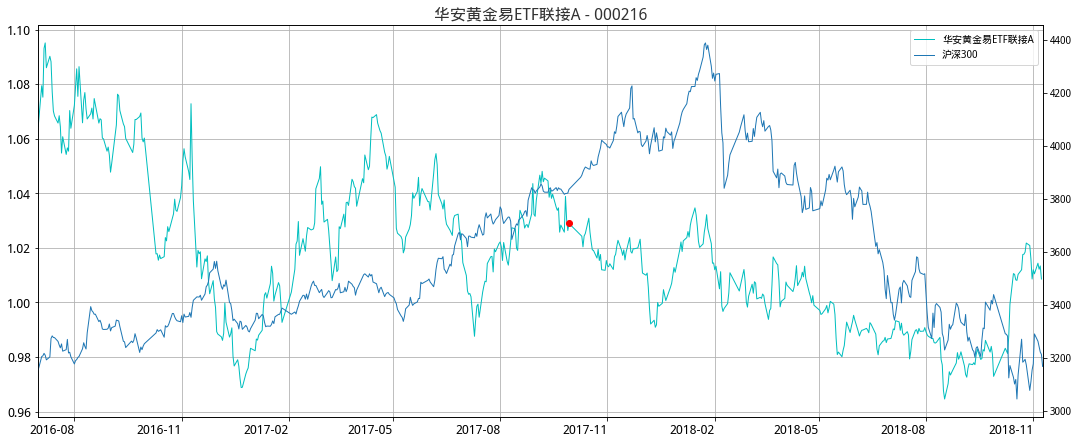

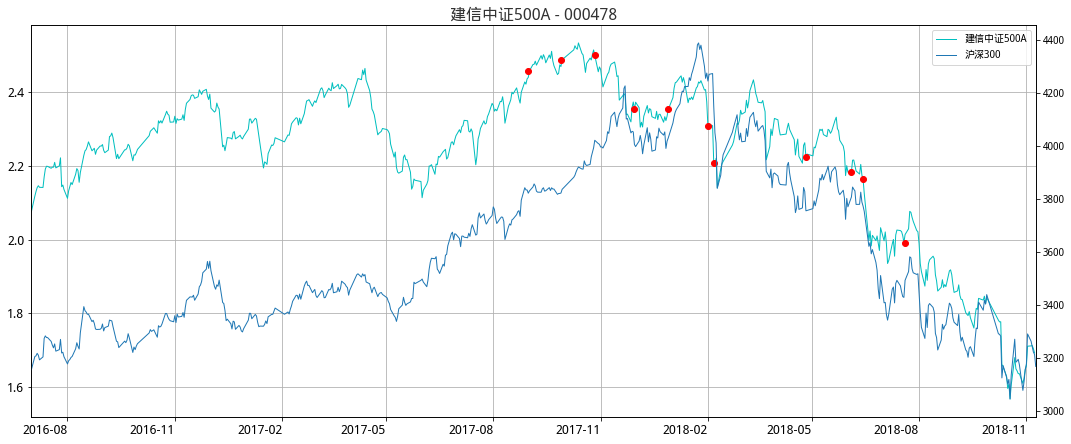

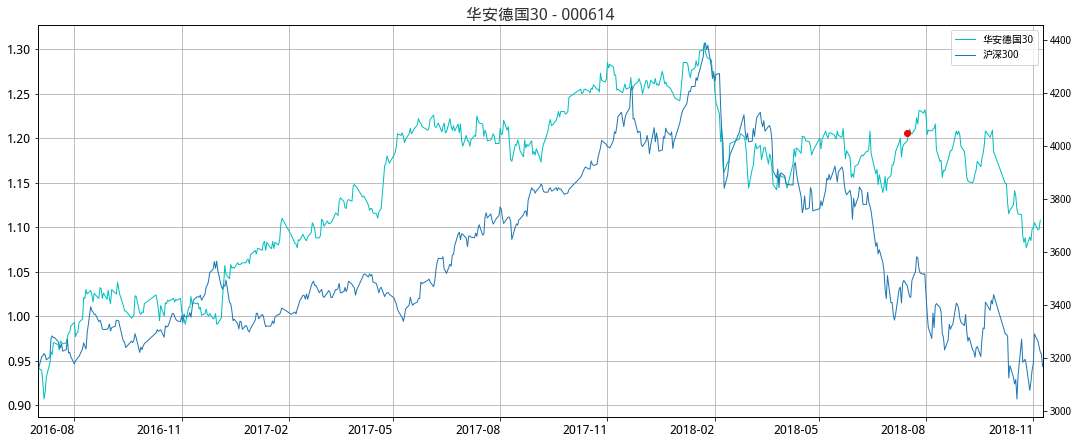

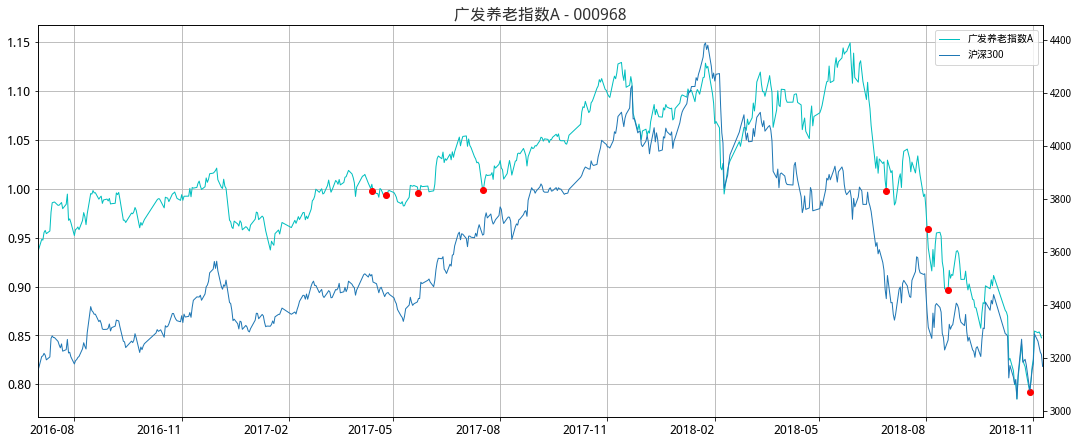

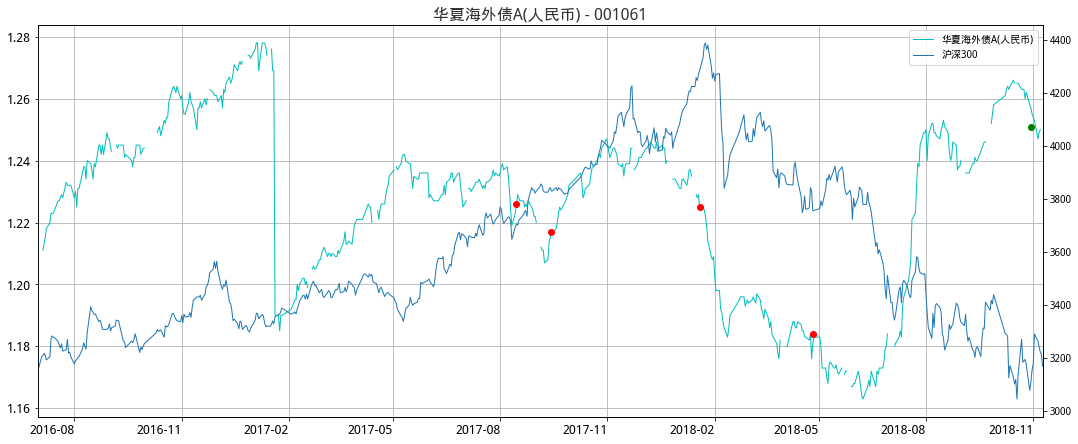

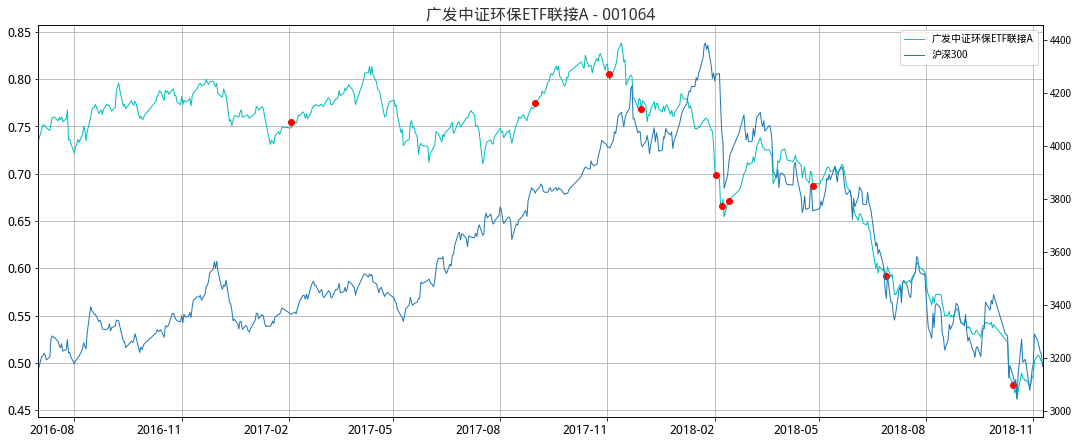

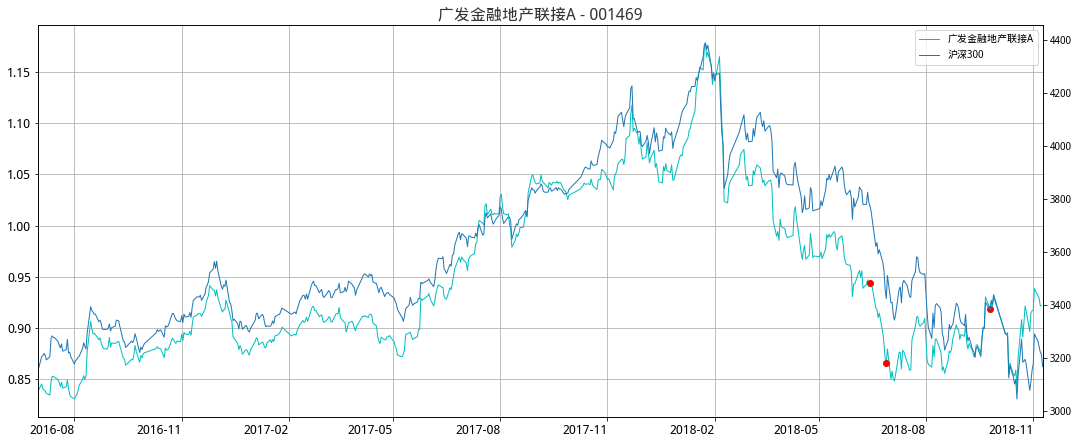

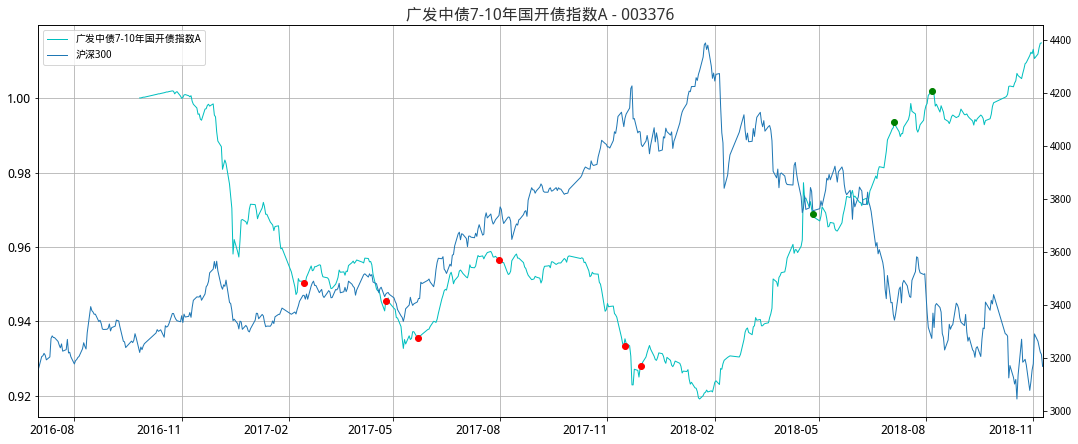

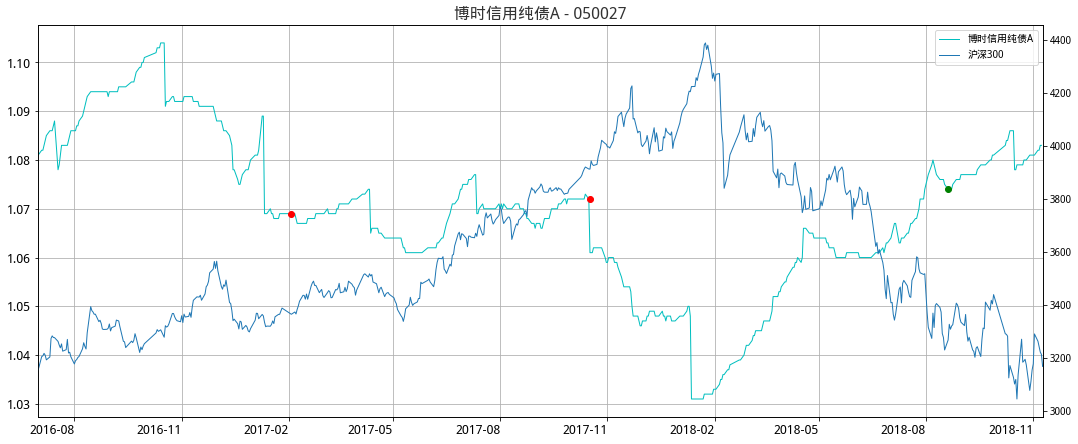

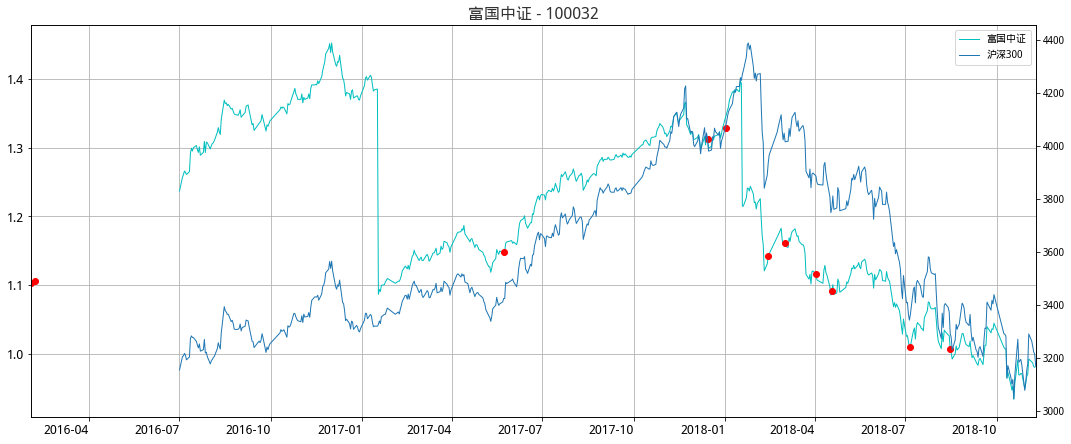

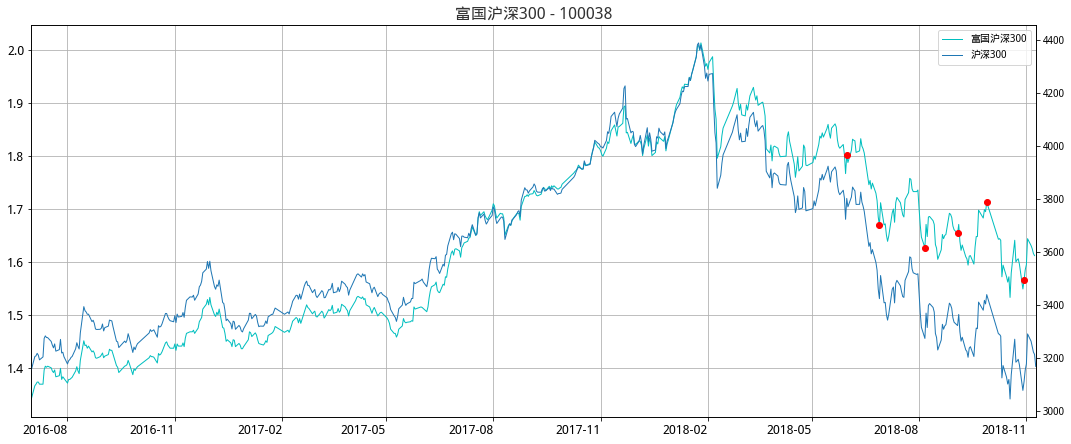

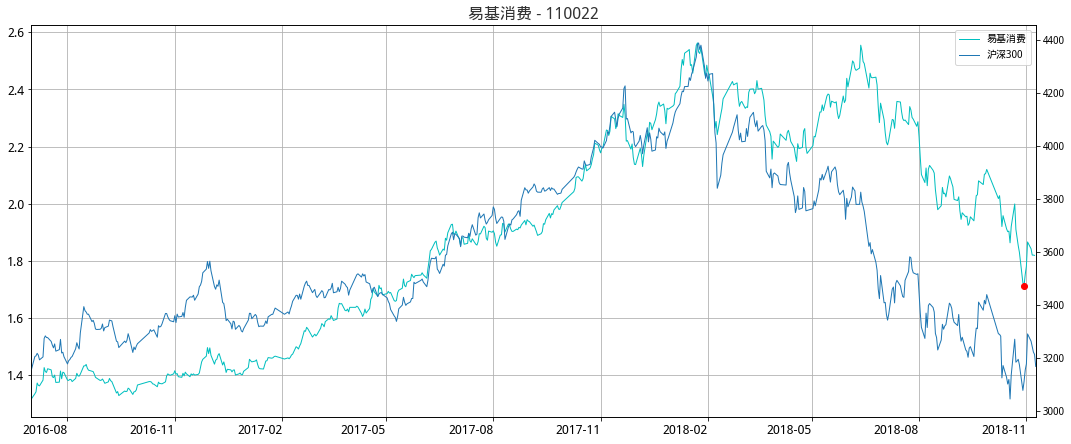

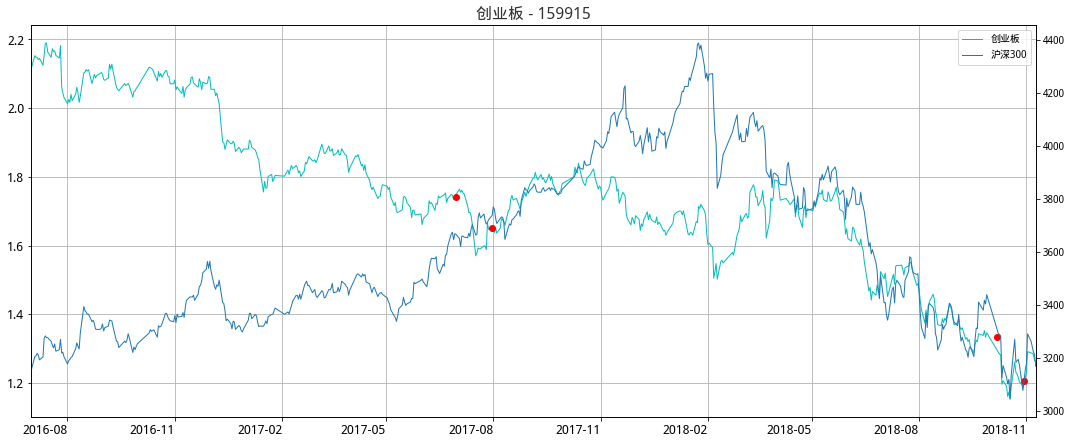

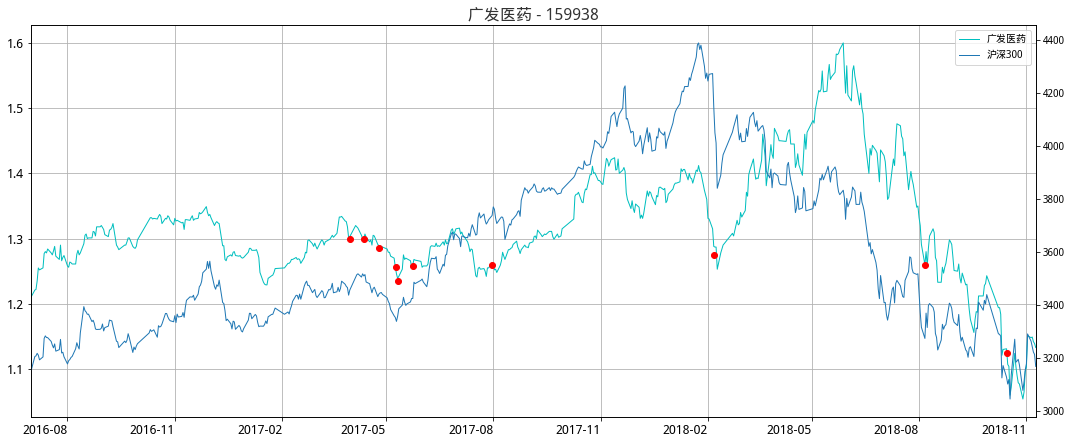

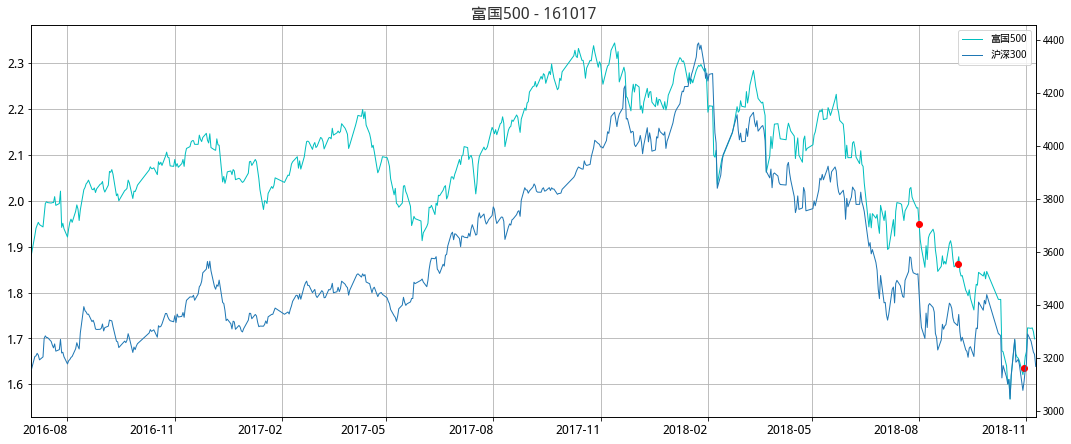

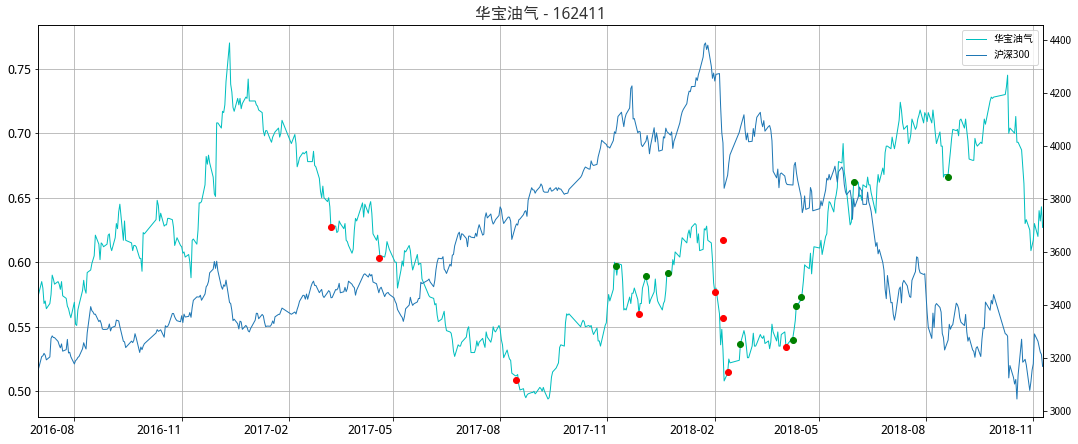

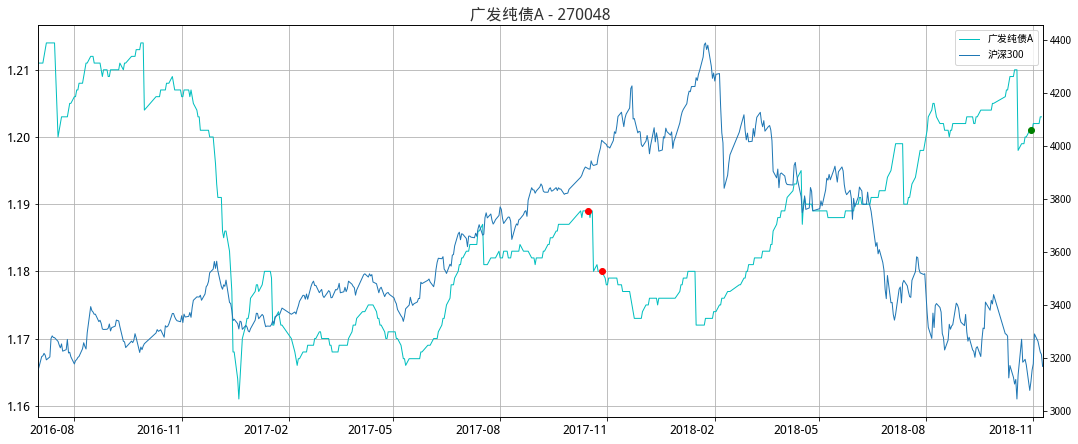

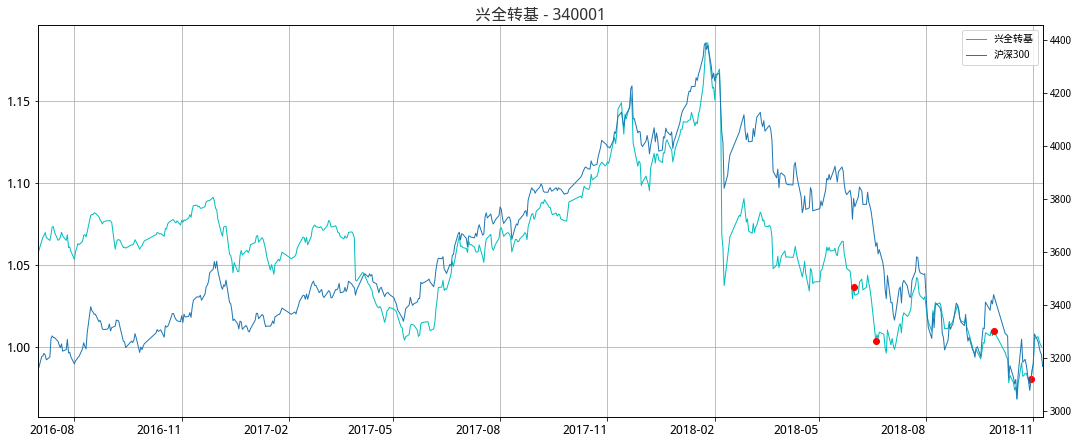

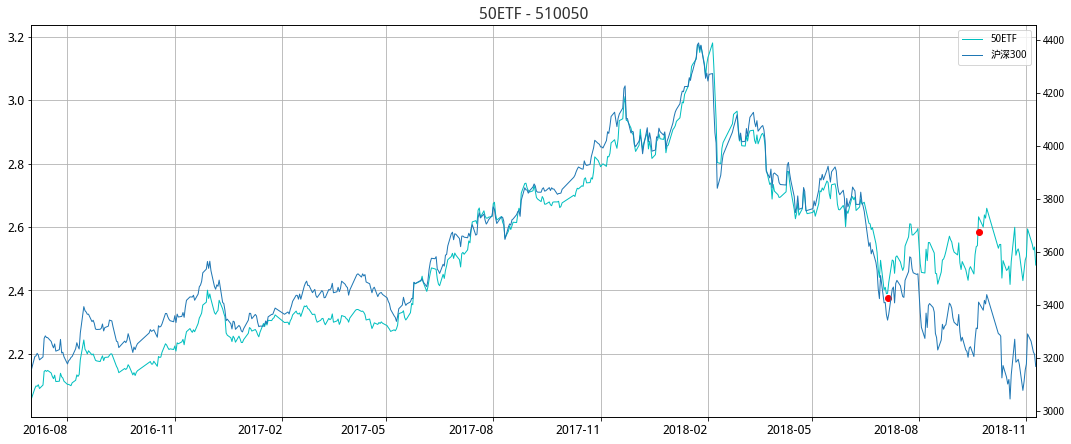

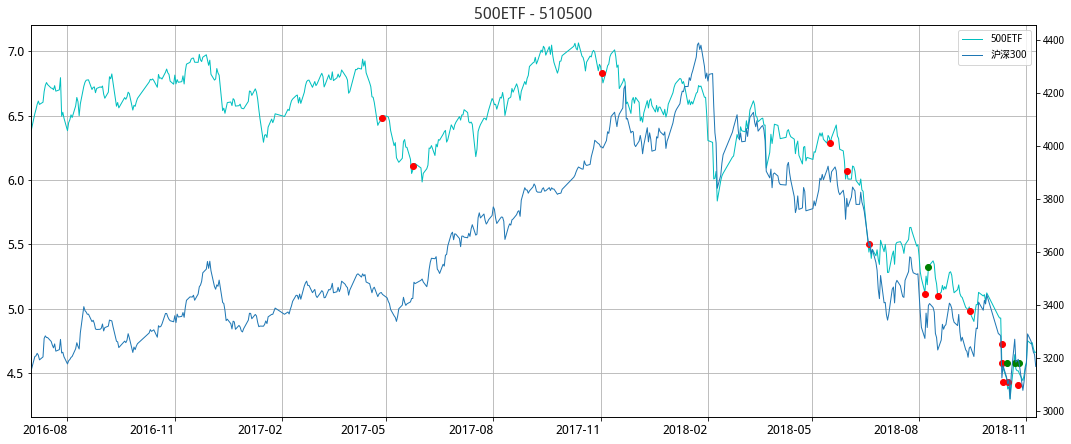

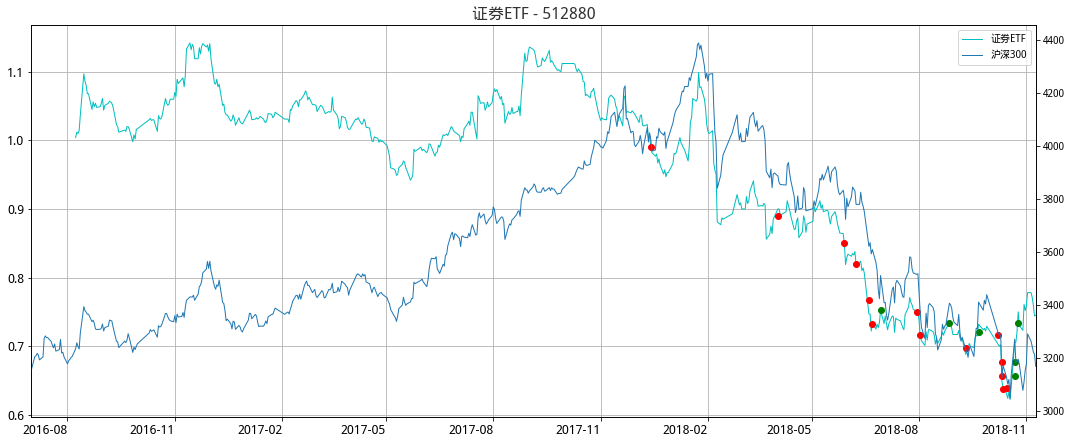

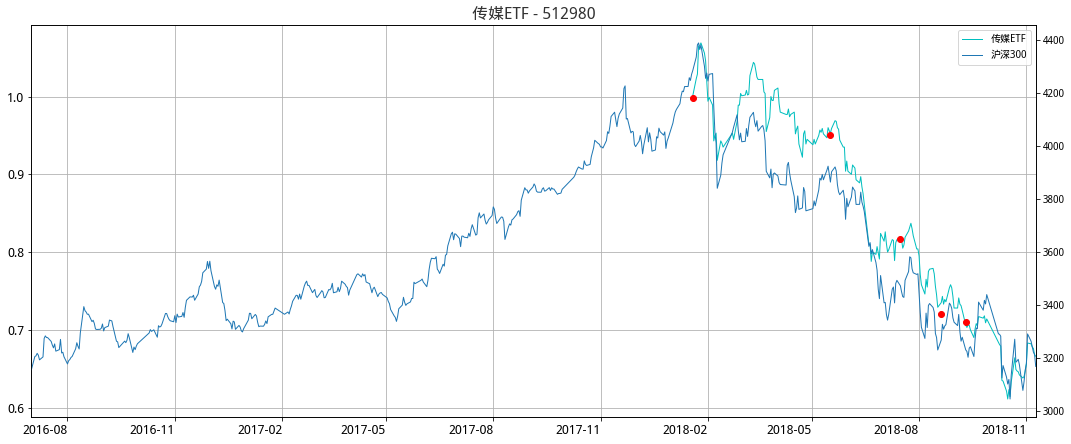

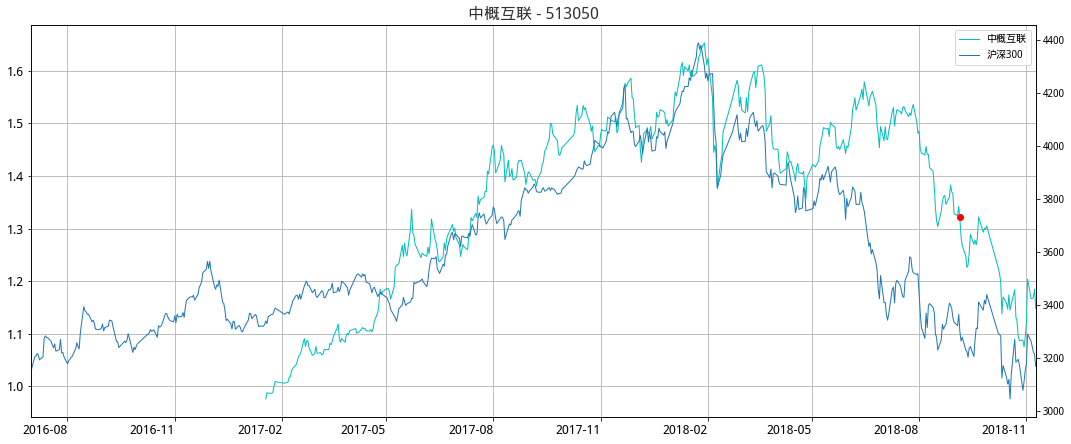

In [3]:
def get_ed_trade():

    # 打开excel文件
    xlr_f=xlrd.open_workbook('基金-定投-ED计划V3.xlsx')

    # 获取第一个表
    table=xlr_f.sheet_by_index(2)

    # 获取日期
    date_list=table.col_values(2)[4:]
    date_list=[xlrd.xldate.xldate_as_datetime(item,datemode=0) for item in date_list if item is not u'']

    # 获取代码
    code_list=table.col_values(4)[4:]
    code_list=[str(item)[:-2].rjust(6,'0') for item in code_list if item is not u'']
    
    # 获取市场类别
    market_list=table.col_values(7)[4:]
    market_list=[item for item in market_list if item is not u'']
    
    # 添加代码后缀
    code_list=[normalize_code(code) if market==u'场内' else u'%s.OF'%(code) for code,market in zip(code_list,market_list) ]
    
    # 获取交易类别
    trade_list=table.col_values(8)[4:]
    trade_list=['buy' if item==u'买入' else 'sell' for item in trade_list if item is not u'']

    # 获取价格
    price_list=table.col_values(12)[4:]
    price_list=[item for item in price_list if item is not u'']

    # 生成数据表
    data_dict={'code':code_list,'trade':trade_list,'price':price_list}
    #print data_dict
    df=pd.DataFrame(data_dict,index=date_list)
    
    return df


def ed_trade(start_date='2016-01-01',end_date=None,index_code='000300.XSHG'):
    """
    开始、结束日期
    start_date
    end_date

    # 对比指数
    compar_code
    """
    
    # 参数检查
    if start_date is None:
        start_date='2016-01-01'
        
    if end_date is None:
        end_date=pd.datetime.today()
        
    if index_code is None:
        index_code='000300.XSHG'
            
        
    # 获取对比指数收盘价
    index_df=get_price(index_code,start_date=start_date,end_date=end_date,frequency='daily',fields=['close'])
    index_name=get_security_info(index_code).display_name
    
    # 读取交易记录
    trade_df=get_ed_trade()
    # 获取所有代码
    code_list=trade_df.groupby('code').count().index

    # 遍历所有代码
    for code in code_list:
        if code.endswith('OF'):    
            # 获取基金净值
            price_df=get_extras('unit_net_value',code,start_date=start_date,end_date=end_date)   
            # 代码对应的名称简称
            fund_name=get_security_info(code).name
        else:
            # 获取收盘价
            price_df=get_price(code,start_date=start_date,end_date=end_date,frequency='daily',fields=['close'])
            # 代码对应的名称全称
            fund_name=get_security_info(code).display_name
        
        price_df.columns=[fund_name]
        
        # 生成图表数据
        # 对比数据
        price_df[index_name]=index_df['close']
        # 买入数据
        buy_df=trade_df[(trade_df['code']==code) & (trade_df['trade']==u'buy')]['price']
        # 卖出数据
        sell_df=trade_df[(trade_df['code']==code) & (trade_df['trade']==u'sell')]['price']


        # 价格及对比指数图
        ax=price_df.plot(figsize=(18,8),
                         secondary_y=[index_name],
                         fontsize=12.5,linewidth=1,grid=True,mark_right=False,rot=0,
                         style=['c']
                        )
        
#         r_ax=ax.twinx()
#         index_df.plot(figsize=(18,8),ax=r_ax,
#                          fontsize=12.5,linewidth=1,grid=False,mark_right=False,rot=0,
#                          style=['orange']
#                         )
        
        # 买入、卖出，有可能同一日多个数据，所以需要分别绘制
        # 买入价格图
        buy_df.plot(figsize=(18,8),ax=ax,
                         fontsize=12.5,linewidth=1,grid=True,mark_right=False,rot=0,
                         style=['ro'])
        # 卖出价格图
        if len(sell_df)>0:
            sell_df.plot(figsize=(18,8),ax=ax,
                             fontsize=12.5,linewidth=1,grid=True,mark_right=False,rot=0,
                             style=['go'])
        # 标题    
        ax.set_title('%s - %s'%(fund_name,code[0:6]),fontsize=16,alpha=0.8) 
        
        
ed_trade(start_date='2016-07-01')

In [2]:
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import Layout


wdate=widgets.DatePicker(
#     options={'2018-07-06': 1, '2018-07-09': 2, '2018-07-10': 3},
#     value=2,
    description=u'日期',
    layout=Layout(width='240px'),
    margin=4
)

wcode=widgets.Dropdown(
    options={'510500 500ETF': 1, 'Two': 2, 'Three': 3,'510501 500ETF': 4, 'Two1': 5, 'Three1': 6},
    value=1,
    description=u'代码',
    layout=Layout(width='240px'),
    margin=4
)
wpt=widgets.Dropdown(
    options={u'华泰证券': 1, '天天基金': 2},
    value=1,
    description=u'平台',
    layout=Layout(width='240px'),
    margin=4
)

wtrade=widgets.Dropdown(
    options=[u'买',u'卖'],
    value=u'买',
    description=u'交易',
    disabled=False,
    layout=Layout(width='180px',orientation='horizontal'),
    margin=4
)
wn=widgets.BoundedIntText(
    value=100,
    min=100,
    max=5000,
    step=10,
    description=u'数量',
    disabled=False,
    layout=Layout(width='180px'),
    margin=4
)
wprice=widgets.BoundedIntText(
    value=100,
    min=100,
    max=5000,
    step=10,
    description=u'数量',
    disabled=False,
    layout=Layout(width='180px'),
    margin=4
)
wprice=widgets.BoundedFloatText(
    value=7.5,
    min=0.000,
    max=1000.000,
    step=0.1,
    description=u'价格',
    disabled=False,
    layout=Layout(width='180px'),
    margin=4
)
wprice2=widgets.BoundedFloatText(
    value=7.5,
    min=0.000,
    max=1000.000,
    step=0.1,
    description=u'成交金额',
    disabled=True,
    layout=Layout(width='180px'),
    margin=4
)
wprice3=widgets.BoundedFloatText(
    value=7.5,
    min=0.000,
    max=1000.000,
    step=0.1,
    description=u'费用',
    disabled=True,
    layout=Layout(width='180px'),
    margin=4
)
wprice4=widgets.BoundedFloatText(
    value=7.5,
    min=0.000,
    max=1000.000,
    step=0.1,
    description=u'发生金额',
    disabled=True,
    layout=Layout(width='180px'),
    margin=4
)
wsave=widgets.Button(
    description=u'保存交易',
    disabled=False,
    button_style='success',
    layout=Layout(width='120px'),
    margin=4

)
wundo=widgets.Button(
    description=u'撤销保存',
    disabled=False,
    button_style='warning',
    layout=Layout(width='120px'),
    margin=4

)
container=widgets.HBox([
                        widgets.VBox([wdate,wcode,wpt],layout=Layout(width='280px')),
                        widgets.VBox([wtrade,wn,wprice]),
                    widgets.VBox([]),
                       widgets.VBox([wprice2,wprice3,wprice4],layout= Layout(display='flex',
                    flex_flow='column',
                    align_items='stretch',
                 )),    
                     widgets.VBox([]),
                       widgets.VBox([wsave,wundo])
                        ],
                       )


display(container)
# wprice3.layout.visibility="hidden"

SEJveChjaGlsZHJlbj0oVkJveChjaGlsZHJlbj0oRGF0ZVBpY2tlcih2YWx1ZT1Ob25lLCBkZXNjcmlwdGlvbj11J1x1NjVlNVx1NjcxZicsIGxheW91dD1MYXlvdXQod2lkdGg9dScyNDBweCfigKY=


In [16]:
widgets.SelectionSlider(
    options=['10年', '5年', '3年', '所有'],
    value='10年',
    #description=u'数据',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    layout=Layout(width='180px'),
    readout=True
)

U2VsZWN0aW9uU2xpZGVyKGNvbnRpbnVvdXNfdXBkYXRlPUZhbHNlLCBsYXlvdXQ9TGF5b3V0KHdpZHRoPXUnMTgwcHgnKSwgb3B0aW9ucz0oJzEwXHhlNVx4YjlceGI0JywgJzVceGU1XHhiOVzigKY=


In [21]:
widgets.ToggleButtons(
    options=['Slow', 'Regular', 'Fast'],
    description='Speed:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Description of slow', 'Description of regular', 'Description of fast'],
    layout=Layout(width='180px'),
    icons=['check'] * 3
)

VG9nZ2xlQnV0dG9ucyhkZXNjcmlwdGlvbj11J1NwZWVkOicsIGljb25zPSh1J2NoZWNrJywgdSdjaGVjaycsIHUnY2hlY2snKSwgbGF5b3V0PUxheW91dCh3aWR0aD11JzE4MHB4JyksIG9wdGnigKY=


In [17]:
widgets.ToggleButtons(
    options=['Slow', 'Regular', 'Fast'],
    description='Speed:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Description of slow', 'Description of regular', 'Description of fast'],
    #layout=Layout(max_width='60px'),
#     icons=['check'] * 3
)

VG9nZ2xlQnV0dG9ucyhkZXNjcmlwdGlvbj11J1NwZWVkOicsIG9wdGlvbnM9KCdTbG93JywgJ1JlZ3VsYXInLCAnRmFzdCcpLCB0b29sdGlwcz0odSdEZXNjcmlwdGlvbiBvZiBzbG93JywgdSfigKY=


In [28]:
dir(widgets.ToggleButtons.visibility)

AttributeError: type object 'ToggleButtons' has no attribute 'visibility'

In [1]:
import qgrid
qgrid.enable()
szzs = get_price("000001.XSHG")
szzs
# qgrid_szzs = qgrid.show_grid(szzs)
# qgrid_hs300 = qgrid.show_grid(hs300)

UWdyaWRXaWRnZXQoZ3JpZF9vcHRpb25zPXsnaGlnaGxpZ2h0U2VsZWN0ZWRSb3cnOiBUcnVlLCAnZnVsbFdpZHRoUm93cyc6IFRydWUsICdyb3dIZWlnaHQnOiAyOCwgJ2VuYWJsZUNvbHVtblLigKY=


In [11]:
dir(widgets.RadioButtons.layout)

['__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__get__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__set__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cross_validate',
 '_dynamic_default_callable',
 '_resolve_classes',
 '_resolve_string',
 '_validate',
 'allow_none',
 'class_init',
 'default_args',
 'default_kwargs',
 'default_value',
 'default_value_repr',
 'error',
 'get',
 'get_default_value',
 'get_metadata',
 'help',
 'info',
 'info_text',
 'init_default_value',
 'instance_init',
 'klass',
 'make_dynamic_default',
 'metadata',
 'name',
 'read_only',
 'set',
 'set_metadata',
 'tag',
 'this_class',
 'validate']